In [3]:
%matplotlib inline

import math
import os
import sys
import datetime
import csv
import time
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.autograd import Variable
from torch.optim import lr_scheduler
from PIL import Image
import pandas as pd
import numpy as np
import tqdm
from IPython import display
from googleapiclient.discovery import build
from skimage import io, transform
import os
from googleapiclient.http import MediaIoBaseDownload
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import scipy
from scipy import ndimage, misc
from scipy.misc import imshow
import skimage
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data.sampler import SubsetRandomSampler
import shutil
import pdb
import cv2

plt.ion()
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [4]:
trainlabels = pd.read_csv("/home/jupyter/kaggle_data/trainLabels.csv")

In [1]:
!nvidia-smi

Mon Feb 11 17:10:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    59W / 149W |    934MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
trainlabels.loc[:10,["image", "level"]]

In [ ]:
#distribution of classes on kaggle training dataset
trainlabels["level"].plot(kind="hist")

In [ ]:
trainlabels.groupby(['level']).groups.keys()

In [ ]:
trainlabels.groupby(['level']).count()

In [ ]:
classes = list(trainlabels['level'].unique())
print(classes)

In [ ]:
%cd /home/jupyter/kaggle_data/

In [ ]:
## This script is to divide the training dataset into categorical directories
dataset = open('/home/jupyter/kaggle_data/trainLabels.csv', newline='')
datalist = csv.reader(dataset)
data = list(datalist)
lines = len(data)
i = 0

for row in data:
    image = row[0]+'.jpeg'
    state = row[1]
    print('({}/{}) Processing Image ({}): {}'.format(i + 1, lines, state, image))
    i += 1
    
    if state is '0':
        try:
            os.rename(image, '/home/jupyter/kaggle_data/train/Normal/' + image)
            print(' -> Moved to Normal')
        except FileNotFoundError:
            print(' -> Failed to find file')
    elif state in ['1','2','3','4']:
        if state is '1':
            try: 
                os.rename(image, '/home/jupyter/kaggle_data/train/Mild_NPDR/'+image)
                print(' -> Moved to Mild_NPDR')
            except FileNotFoundError:
                print('-> Failed to find file')
        elif state is '2':
            try:
                os.rename(image, '/home/jupyter/kaggle_data/train/Moderate_NPDR/'+image)
                print(' -> Moved to Moderate_NPDR')
            except FileNotFoundError:
                print('-> Failed to find file')
        elif state is '3':
            try:
                os.rename(image, '/home/jupyter/kaggle_data/train/Severe_NPDR/'+image)
                print(' -> Moved to Severe_NPDR')
            except FileNotFoundError:
                print('-> Failed to find file')
        elif state is '4':
            try:
                os.rename(image, '/home/jupyter/kaggle_data/train/PDR/'+image)
                print(' -> Moved to PDR')
            except FileNotFoundError:
                print('-> Failed to find file')

In [5]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            return dataset.imgs[idx][1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
TRAIN_MEAN = np.array([0.485, 0.456, 0.406])
TRAIN_STD = np.array([0.229, 0.224, 0.225]) 

train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
    ])

train_dataset = datasets.ImageFolder('/home/jupyter/kaggle_data/Train/', train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
])

val_dataset = datasets.ImageFolder('/home/jupyter/kaggle_data/Val/', val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

In [6]:
# dataloading part
data_dir = '/home/jupyter/kaggle_data/train'

def load_split_train_test(datadir, valid_size = .1):
    
    TRAIN_MEAN = np.array([0.485, 0.456, 0.406])
    TRAIN_STD = np.array([0.229, 0.224, 0.225]) 
    
    train_transform = transforms.Compose([
        transforms.Resize(224),
        #transforms.RandomCrop(224, padding=0, pad_if_needed=False),
#        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation([0, 360], resample=False, expand=False, center=None),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(TRAIN_MEAN, TRAIN_STD)])
    
    test_transform = transforms.Compose([
        transforms.Resize(size=10),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(TRAIN_MEAN, TRAIN_STD)])
    
    train_data = datasets.ImageFolder(datadir, transform=train_transform)
    test_data = datasets.ImageFolder(datadir, transform=test_transform)
    
    print("train_data", train_data)
    #num_train = len(train_data)
    #indices = list(range(num_train))
    #split = int(np.floor(valid_size * num_train))
    
    #np.random.shuffle(indices)
    #train_idx, test_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=32, num_workers = 4)
    testloader = torch.utils.data.DataLoader(test_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=32, num_workers = 4)
    
    #trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=32, num_workers = 4)
    #testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=32, num_workers = 4)
    
    train_size = int((1-valid_size) * len(train_data))
    test_size = len(train_data) - train_size
    print("train and test sizes: ", train_size, test_size)
    return trainloader, testloader, train_size, test_size

trainloader, testloader, train_size, test_size = load_split_train_test(data_dir, .2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#print(testloader.dataset.classes)
classes = ('Mild_NPDR', 'Moderate_NPDR', 'Normal', 'PDR', 'Severe_NPDR')
batch_size = 32

train_data Dataset ImageFolder
    Number of datapoints: 352
    Root Location: /home/jupyter/kaggle_data/train
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             RandomVerticalFlip(p=0.5)
                             ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
                             ToTensor()
                             Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
                         )
    Target Transforms (if any): None
train and test sizes:  281 71


In [ ]:
#print(len(testloader))
test_iter = iter(trainloader)
%time image_batch, label_batch = next(test_iter) 

# Iterate through the dataloader once
# trainiter = iter(trainloader)
# features, labels = next(trainiter)
# features.shape, labels.shape
print(image_batch.shape, image_batch.type()) 
print(label_batch.shape, label_batch.type()) 

TRAIN_MEAN = np.array([0.485, 0.456, 0.406])
TRAIN_STD = np.array([0.229, 0.224, 0.225]) 
grid = torchvision.utils.make_grid(image_batch, nrow=8).cpu().numpy().transpose(1, 2, 0)
grid = TRAIN_STD * grid + TRAIN_MEAN
# The min and max values are very close to 0.0 and 1.0, but
# are just outside because of numerical effects.
grid = np.clip(grid, 0.0, 1.0)
plt.figure(figsize=(15, 15))
plt.imshow(grid)
#print(label_batch)

label_batch = label_batch.numpy().flatten()-1
print(label_batch)
print(' '.join('%4s' % classes[label_batch[j]] for j in range(batch_size)))

In [7]:
#transfer learning model set-up
m = models.resnet18(pretrained=True)

In [ ]:
m.eval()

In [8]:
# setting up my model with final layer customized

class TruncatedResnet(torch.nn.Module):
  
  def __init__(self, orig_resnet):
    super().__init__()
    self.orig_resnet = orig_resnet
    self.final_linear = torch.nn.Linear(512, 5) # TODO
    #self.logsoftmax = torch.nn.LogSoftmax(dim=1)
  
  def forward(self, x):
    x = self.orig_resnet.conv1(x)
    x = self.orig_resnet.bn1(x)
    x = self.orig_resnet.relu(x)
    x = self.orig_resnet.maxpool(x)

    x = self.orig_resnet.layer1(x)
    x = self.orig_resnet.layer2(x)
    x = self.orig_resnet.layer3(x)
    x = self.orig_resnet.layer4(x)

    x = self.orig_resnet.avgpool(x)    
    x = x.view(x.size(0), -1)
    
    x = self.final_linear(x) # TODO
    #x = self.logsoftmax(x)
    print("here final: ", x.size())
    return x

In [9]:
# loading my model onto tm variable
tm = TruncatedResnet(m)
tm.to(device);

In [10]:
# setting up the optimizer
#optimizer = torch.optim.Adam(tm.final_linear.parameters(), lr=0.001, weight_decay=0.005) # TODO
optimizer = optim.SGD(tm.parameters(), lr=0.001, momentum=0.9)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
weights = torch.tensor([0.0275, 0.291, 0.134,  0.811, 1])
class_weights=torch.FloatTensor(weights).cuda()
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

In [ ]:
epoch = 0
epochs = []
train_losses, train_errors = [], []
val_losses, val_errors = [], []

In [ ]:
def train_for_one_epoch(model, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0

    scheduler.step()
    model.train() # Set model to training mode
    
    for input_batch, label_batch in trainloader:
        input_batch = Variable(input_batch.cuda())
        label_batch = Variable(label_batch.cuda())
        
        p_batch = label_batch.float()
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            logits = model(input_batch)
            _, preds = torch.max(logits, 1)
            loss = criterion(logits, p_batch.long())
            pred_batch = (logits >= 0.0).long()
            loss.backward()
            optimizer.step()
        
            error_rate = 1.0 - (preds == label_batch).float().mean()
            #running_loss += loss.item() * input_batch.size(0)
            running_corrects += torch.sum(preds == label_batch.data)
            
        return loss.item(), error_rate.item(), running_corrects.item()

In [ ]:
# Validation function
def val(model, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    model.eval()
    
    for image_batch, label_batch in testloader:
        image_batch = Variable(image_batch.cuda())
        label_batch = Variable(label_batch.cuda())
        
        p_batch = label_batch.float()
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            logits = model(image_batch)
            _, preds = torch.max(logits, 1)
            loss = criterion(logits, p_batch.long())
            pred_batch = (logits >= 0.0).long()
            
            error_rate = 1.0 - (preds == label_batch).float().mean()
            running_loss += loss.item() * image_batch.size(0)
            running_corrects += torch.sum(preds == label_batch.data)
            
        return loss.item(), error_rate.item(), running_loss.item(), running_corrects.item()

In [ ]:
epoch = 0
epochs = []
train_losses, train_errors= [], []
val_losses, val_errors = [], []
num_epochs = 50

for epoch in range(num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(tm.state_dict())
    best_acc = 0.0
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    epochs.append(epoch)
    train_loss, train_error, training_run_corrects = train_for_one_epoch(tm, criterion, optimizer, exp_lr_scheduler)
    train_losses.append(train_loss)
    train_errors.append(train_error)
    train_epoch_loss = training_run_loss / train_size
    train_epoch_acc = training_run_corrects / train_size
    print(' Train Loss: {:.4f} Train Acc: {:.4f}'.format(train_epoch_loss, train_epoch_acc))

    val_loss, val_error, val_run_loss, val_run_corrects = val(tm, criterion, optimizer, exp_lr_scheduler)
    val_losses.append(val_loss)
    val_errors.append(val_error)       
    val_epoch_loss = val_run_loss / test_size
    val_epoch_acc = val_run_corrects / test_size
    print(' Val Loss: {:.4f} Val Acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))
    
    print(f'Epoch {epoch:3d}. Approx. train error rate: {train_error:.3f}. Val error rate: {val_error:.3f}.')
    
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(tm.state_dict())
    

plot(train_losses)
plot(train_errors)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

#load best model weights
tm.load_state_dict(best_model_wts)

In [11]:
# training function
def train_for_one_epoch():
    tm.eval()
    
    for input_batch, label_batch in trainloader:
        image_batch = Variable(input_batch.cuda())
        label_batch = Variable(label_batch.cuda())
        label_batch = label_batch.cpu().numpy()
        label_batch = label_batch-1
        label_batch = Variable(torch.FloatTensor(label_batch).cuda())
        p_batch = label_batch.long()
      
        logits = tm(image_batch)
        print(logits)
        print("p_batch", p_batch)
        _, preds = torch.max(logits, 1)
        print(preds)
        
        loss = criterion(logits, p_batch)
        print(loss)
        #pred_batch = (logits >= 0.0).long()
        
        error_rate = 1.0 - (preds == p_batch).float().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item(), error_rate.item()

In [12]:
# Validation function
def val():
    tm.eval()
    image_batch, label_batch = next(iter(testloader))
    image_batch = Variable(image_batch.cuda())
    label_batch = Variable(label_batch.cuda())
    label_batch = label_batch.cpu().numpy()
    label_batch = label_batch-1
    label_batch = Variable(torch.FloatTensor(label_batch).cuda())
    p_batch = label_batch.long()
    logits = tm(image_batch)
    _, preds = torch.max(logits, 1)
    loss = criterion(logits, p_batch)
    
#    pred_batch = (logits >= 0.0).long()
    error_rate = 1.0 - (preds == p_batch).float().mean()
    
    return loss.item(), error_rate.item()

In [13]:
epoch = 0
epochs = []
train_losses, train_errors = [], []
val_losses, val_errors = [], []
num_epochs = 25

Epoch 0/24
--------------------
here final:  torch.Size([32, 5])
tensor([[-0.6495, -0.6140,  0.3600,  0.3853, -0.0608],
        [-0.6150, -0.0882,  0.2993,  0.8451, -0.5355],
        [-0.9013,  0.0106, -0.0058,  0.0966,  0.0134],
        [-0.1519, -0.7969,  0.3264,  0.0828, -0.5045],
        [-0.5542, -0.0828, -0.3893,  0.2502, -0.3009],
        [-0.6826, -0.5291,  0.0026, -0.1878, -0.5418],
        [-0.3099, -0.4554,  0.6402, -0.2455, -0.2003],
        [-0.6271, -0.7861, -0.4228,  0.5153,  0.0385],
        [-0.9434, -0.3490,  0.1190,  0.5948, -0.2252],
        [-0.4410, -0.1217,  0.2613,  0.4764, -0.7457],
        [-0.7803,  0.0359,  0.3188, -0.1432, -0.3970],
        [-0.4159, -0.5195,  0.2106,  0.0685, -0.2470],
        [ 0.4693, -0.0408,  0.3598, -0.4040, -0.5803],
        [-0.4521, -0.7365,  0.2873,  0.4296, -0.2998],
        [ 0.2754, -0.9153,  0.4961,  0.0494, -0.2434],
        [-0.0601, -0.7049,  0.3544,  0.2880, -0.2478],
        [-0.6885, -0.0562,  0.1023,  0.5583, -0.0655],


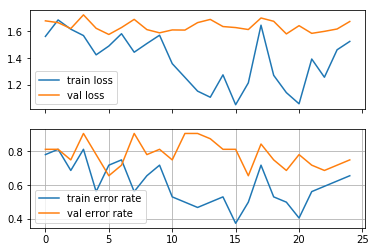

In [14]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 20)
    train_loss, train_error = train_for_one_epoch()
    val_loss, val_error = val()
    
    epoch += 1
    epochs.append(epoch)
    
    train_losses.append(train_loss)
    train_errors.append(train_error)
    val_losses.append(val_loss)
    val_errors.append(val_error)
    
    print(f'Epoch {epoch:3d}. Approx. train error rate: {train_error:.3f}. Val error rate: {val_error:.3f}.')

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(train_losses, label='train loss')
ax[0].plot(val_losses, label='val loss')
ax[0].legend()
ax[1].plot(train_errors, label='train error rate')
ax[1].plot(val_errors, label='val error rate')
ax[1].legend()
plt.grid(True)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
Labels = Variable(labels.cuda())
label_batch = Labels.float()
grid = torchvision.utils.make_grid(images, nrow=8).cpu().numpy().transpose(1, 2, 0)
grid = TRAIN_STD * grid + TRAIN_MEAN

# The min and max values are very close to 0.0 and 1.0, but
# are just outside because of numerical effects.
grid = np.clip(grid, 0.0, 1.0)
plt.figure(figsize=(15, 15))
plt.imshow(grid)
label_batch = label_batch.cpu().numpy()
label_batch = label_batch-1
label_batch = Variable(torch.FloatTensor(label_batch).cuda())
label_batch = label_batch.int()
print(label_batch)
print(' '.join('%5s' % classes[label_batch[j]] for j in range(batch_size)))

In [ ]:
outputs = tm(images.cuda())
_, predicted = torch.max(outputs, 1)
print(predicted)

print("Val error_rate: ", 1-(predicted.int() == label_batch).float().mean())

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        labels = labels.cpu().numpy()
        labels = labels-1
        labels = torch.FloatTensor(labels).cuda()
        outputs = tm(images)
        
        _, predicted = torch.max(outputs.data, 1)
        print(labels)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

import sys
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.cuda()
        labels = labels.cuda()
        labels = labels.cpu().numpy()
        labels = labels-1
        labels = torch.FloatTensor(labels).cuda()
        
        outputs = tm(images)
        
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.long()).squeeze()
        if len(labels) > 0:
            for i in range(len(c)):
                label = labels[i]
                print(c)
                class_correct[label.int().item()] += c[i].int().item()
                class_total[label.int().item()] += 1
        elif len(c) == 0:
            label = labels[0]
            class_correct[label.int().item()] += c.item()
            class_total[label.int().item()] += 1
            
print(class_correct)
print(class_total)

for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))